In [1]:
#Import the necessary packages
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random
import re
import os
from collections import Counter
import pickle
import warnings
warnings.filterwarnings('ignore')

# Advanced libraries for NLP and ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# For sentiment analysis and advanced text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer


In [2]:
# Download required NLTK data
try:
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab', quiet = True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('vader_lexicon', quiet=True)
except:
    print("NLTK downloads not completed")


## **Table of Content**
Data Generation for Model Training

1.  **Data Generation for Model Training:** Describes the approach followed for synthetic email generation to simulate real-world training data.
2.  **Multi-Modal Email Classification:**
Explains the strategy used to classify emails by combining multiple input features such as text and structured metadata.
3. **Named Entity Recognition and Extraction:**
Details the use of NLP techniques to extract entities like names, organizations, dates, and locations from email bodies.
4. **Named Entity Recognition and Extraction:**
Details the use of NLP techniques to extract entities like names, organizations, dates, and locations from email bodies.
5. **Data Visualization:**
Presents visual insights from the email dataset to understand distribution, trends, and model performance.
6. **Email Priority Scoring:**
Describes the logic for assigning a priority score to emails based on urgency, keywords, and metadata.
7. **Email Routing to Corresponding Departments:**
Outlines the method used to reroute emails to the appropriate departments or teams based on content classification.

8. **Processing Pipeline:**
Summarizes the step-by-step integration of modules to form a cohesive processing pipeline.
9. **End-to-End Pipeline Demonstration:**
Demonstrates the complete workflow from receiving emails to final output using a unified pipeline.


## 1. Generating Train data- Emails
Generates a diverse set of synthetic customer support emails for various intents:



*   Refund requests
*   Technical issues

*  Account inquiries

*   Product questions


Uses predefined templates with dynamic placeholders for:

*  Customer names

*   Product names

*  Issue types

*   Dates and order IDs


**generate_date()** creates realistic, recently biased dates

**generate_order_id()** simulates unique order numbers

**add_noise_and_variants()**introduces edge cases like:Typos Random casing, Urgency markers (e.g., “URGENT:”)

**generate_emails()**:Randomly selects an intent and fills a matching template, Adds noise and urgency indicators, Computes a basic sentiment score, Assigns an urgency level, Compiles everything into a structured dataset for training






In [3]:
class AdvancedEmailGenerator:
    """
    Advanced email generator awith edge cases to test model robustness.
    """

    def __init__(self):
        self.sentiment_analyzer = SentimentIntensityAnalyzer()
        self.lemmatizer = WordNetLemmatizer()

        # Synthetic email patterns
        self.email_patterns = {
            "refund_request": {
                "subjects": [
                    "URGENT: Refund needed for order #{order_id}",
                    "Disappointed with {product} - requesting refund",
                    "Defective {product} - immediate refund required",
                    "Return authorization for {product}",
                    "Quality issue with {product} purchased on {date}"
                ],
                "bodies": [
                    "Dear Support Team,\n\nI am extremely disappointed with the {product} I received on {date}. The item is completely unusable and I demand a full refund immediately. My name is {customer_name} and this is unacceptable service.\n\nOrder: #{order_id}\nExpected resolution: Full refund\n\nRegards,\n{customer_name}",
                    "Hello,\n\nI'm {customer_name} and I need to return the {product} I purchased on {date}. It arrived damaged and doesn't work as advertised. Please process a refund for order #{order_id}.\n\nThanks,\n{customer_name}",
                    "Hi there,\n\nThe {product} I ordered on {date} is not meeting my expectations. I would like to request a full refund. My details:\n- Name: {customer_name}\n- Order: #{order_id}\n- Issue date: {date}\n\nPlease advise on the return process.",
                    "Subject: Refund Request - {product}\n\nI'm writing to request a refund for the {product} purchased on {date}. The product stopped working after {days_used} days of use. This is clearly a quality issue.\n\nCustomer: {customer_name}\nOrder ID: #{order_id}\nAction needed: Full refund\n\nThank you for your assistance."
                ],
                "typical_actions": ["refund", "return", "money back", "cancel order"]
            },
            "technical_issue": {
                "subjects": [
                    "HELP: {product} not working properly",
                    "Technical support needed for {product}",
                    "Bug report: {product} malfunction",
                    "Troubleshooting assistance required",
                    "{product} connectivity issues since {date}"
                ],
                "bodies": [
                    "Dear Technical Support,\n\nI'm {customer_name} and I'm experiencing serious issues with my {product} since {date}. The device keeps {issue_type} and I've tried all basic troubleshooting steps. I need immediate technical assistance.\n\nOrder: #{order_id}\nIssue: {issue_type}\nUrgency: High\n\nPlease help!",
                    "Hello,\n\nMy {product} has been malfunctioning since {date}. I'm {customer_name} and I need help troubleshooting this issue. The problem is: {issue_type}.\n\nCan you provide a solution or send a replacement?",
                    "Hi Support Team,\n\nI need technical help with my {product}. It started {issue_type} on {date} and now it's unusable. I'm {customer_name}, order #{order_id}.\n\nWhat troubleshooting steps do you recommend?",
                    "Technical Issue Report:\n\nCustomer: {customer_name}\nProduct: {product}\nProblem: {issue_type} since {date}\nOrder: #{order_id}\n\nI've tried restarting and updating firmware but the issue persists. Please provide technical guidance."
                ],
                "typical_actions": ["troubleshooting", "repair", "replacement", "technical support", "diagnostic"]
            },
            "account_inquiry": {
                "subjects": [
                    "Account access problem - {customer_name}",
                    "Unable to log into my account",
                    "Account verification needed",
                    "Password reset request",
                    "Billing question about my account"
                ],
                "bodies": [
                    "Dear Account Support,\n\nI'm {customer_name} and I've been locked out of my account since {date}. I can't access my order history or account settings. Please help me regain access.\n\nEmail: {customer_name}@email.com\nLast login: {date}\n\nUrgent assistance needed.",
                    "Hello,\n\nI'm having trouble with my account. I'm {customer_name} and I noticed some unusual activity on {date}. Can you help me verify my account security?\n\nPlease contact me ASAP.",
                    "Hi there,\n\nI need to update my account information but I'm having technical difficulties. My name is {customer_name} and I last tried accessing my account on {date}.\n\nCan you guide me through the process?",
                    "Account Inquiry:\n\nName: {customer_name}\nIssue: Cannot access account since {date}\nNeeded: Password reset and account verification\n\nPlease help me resolve this quickly."
                ],
                "typical_actions": ["password reset", "account unlock", "verification", "account update", "security check"]
            },
            "product_inquiry": {
                "subjects": [
                    "Questions about {product} specifications",
                    "Compatibility inquiry for {product}",
                    "Feature information needed",
                    "Pre-purchase questions about {product}",
                    "Technical specifications for {product}"
                ],
                "bodies": [
                    "Dear Sales Team,\n\nI'm {customer_name} and I'm interested in purchasing the {product}. I have some questions about its features and compatibility. I researched this on {date}.\n\nSpecific questions:\n- Battery life?\n- Warranty details?\n- Compatibility with {device_type}?\n\nPlease provide detailed information.",
                    "Hello,\n\nI'm considering buying the {product} and need more information. My name is {customer_name}. I saw the product on {date} but need clarification on:\n\n1. Technical specifications\n2. Warranty coverage\n3. Return policy\n\nThank you for your help.",
                    "Hi,\n\nI'm {customer_name} and I have questions about the {product}. I was browsing your website on {date} and couldn't find information about {feature_inquiry}.\n\nCan you provide more details?",
                    "Product Inquiry:\n\nCustomer: {customer_name}\nProduct: {product}\nInquiry date: {date}\nQuestions: Features, compatibility, pricing\n\nPlease send detailed product information."
                ],
                "typical_actions": ["information", "product details", "specifications", "consultation", "quote"]
            }
        }

        # Data for emails
        self.customer_names = [
            "Sarah Johnson", "Michael Chen", "Emma Rodriguez", "David Kim", "Lisa Zhang",
            "Robert Wilson", "Maria Garcia", "James Thompson", "Jennifer Lee", "Daniel Brown",
            "Ashley Davis", "Kevin Martinez", "Rachel Anderson", "Thomas Taylor", "Jessica White",
            "Christopher Moore", "Amanda Jackson", "Matthew Martin", "Samantha Lewis", "Nicholas Clark"
        ]

        self.products = [
            "UltraSound Pro Bluetooth Speaker", "SmartFit 5G Fitness Tracker", "AirPods Pro Max",
            "RoboClean X200 Vacuum", "PowerBank Ultra 20000mAh", "GameMaster Wireless Mouse",
            "ErgoType Mechanical Keyboard", "LuminaLED Smart Bulb", "FitTrack Advanced Watch",
            "ActionCam 4K Pro", "NoiseGuard Headphones", "SonicBrush Electric Toothbrush",
            "AirFry Master 3000", "BrewPerfect Coffee Maker", "SkyDrone Explorer", "VR Vision Pro",
            "ReadMaster E-Reader", "DashCam HD Plus", "ChargeStation Wireless", "SmartHome Hub"
        ]

        self.issue_types = [
            "freezing randomly", "not connecting to WiFi", "battery draining quickly",
            "overheating", "producing poor sound quality", "screen flickering",
            "not responding to touch", "charging port loose", "software crashing",
            "bluetooth connectivity issues", "poor battery life", "physical damage upon arrival"
        ]

        self.device_types = ["iPhone", "Android phone", "Windows laptop", "MacBook", "iPad", "PC"]
        self.feature_inquiries = ["waterproof rating", "battery specifications", "warranty terms", "color options"]

    def generate_date(self, start_year=2023, end_year=2024):
        """Generate realistic dates with recent bias"""
        start_date = datetime(start_year, 1, 1)
        end_date = datetime(end_year, 12, 31)
        # Bias towards more recent dates
        time_delta = end_date - start_date
        random_days = int(np.random.exponential(scale=time_delta.days/4))
        random_days = min(random_days, time_delta.days)
        return (start_date + timedelta(days=random_days)).strftime("%Y-%m-%d")

    def generate_order_id(self):
        """Generate realistic order IDs"""
        return f"ORD{random.randint(100000, 999999)}"

    def add_noise_and_variants(self, email_content):
        """Add realistic variations and noise to emails"""
        # Random typos and variations
        if random.random() < 0.1:  # 10% chance of typos
            email_content = re.sub(r'\bthe\b', 'teh', email_content, count=1)

        # urgency markers
        if random.random() < 0.3:  # 30% chance
            urgency_markers = ["URGENT:", "ASAP:", "PRIORITY:", "IMMEDIATE ATTENTION:"]
            email_content = f"{random.choice(urgency_markers)} {email_content}"

        return email_content

    def generate_emails(self, num_emails=50):
        """Generate email dataset"""
        emails = []

        for i in range(num_emails):
            # Choose intent with  distribution
            intent_weights = [0.35, 0.25, 0.20, 0.20]  # refund, technical, account, product
            intent = np.random.choice(list(self.email_patterns.keys()), p=intent_weights)

            pattern = self.email_patterns[intent]

            # Generate email components
            customer_name = random.choice(self.customer_names)
            product = random.choice(self.products)
            date = self.generate_date()
            order_id = self.generate_order_id()
            issue_type = random.choice(self.issue_types)
            device_type = random.choice(self.device_types)
            feature_inquiry = random.choice(self.feature_inquiries)
            days_used = random.randint(1, 30)

            # Create email content
            subject = random.choice(pattern["subjects"]).format(
                product=product, order_id=order_id, date=date, customer_name=customer_name
            )

            body = random.choice(pattern["bodies"]).format(
                customer_name=customer_name, product=product, date=date,
                order_id=order_id, issue_type=issue_type, device_type=device_type,
                feature_inquiry=feature_inquiry, days_used=days_used
            )

            # Add variations and noise
            full_content = f"Subject: {subject}\n\n{body}"
            full_content = self.add_noise_and_variants(full_content)

            # Calculate sentiment
            sentiment = self.sentiment_analyzer.polarity_scores(full_content)

            emails.append({
                "id": f"email_{i+1:03d}",
                "subject": subject,
                "body": body,
                "full_content": full_content,
                "true_intent": intent.replace("_", " "),
                "true_customer": customer_name,
                "true_product": product,
                "true_date": date,
                "true_action": random.choice(pattern["typical_actions"]),
                "sentiment_score": sentiment['compound'],
                "urgency_level": "high" if any(word in full_content.lower() for word in ["urgent", "asap", "immediate", "emergency"]) else "medium"
            })

        return emails

**Example output:**

{'id': 'email_001',

  'subject': 'Quality issue with UltraSound Pro Bluetooth Speaker purchased on 2023-07-09',

  'body': 'Dear Support Team,\n\nI am extremely disappointed with the UltraSound Pro Bluetooth Speaker I received on 2023-07-09. The item is completely unusable and I demand a full refund immediately. My name is Amanda Jackson and this is unacceptable service.\n\nOrder: #ORD816793\nExpected resolution: Full refund\n\nRegards,\nAmanda Jackson',

  'full_content': 'Subject: Quality issue with UltraSound Pro Bluetooth Speaker purchased on 2023-07-09\n\nDear Support Team,\n\nI am extremely disappointed with the UltraSound Pro Bluetooth Speaker I received on 2023-07-09. The item is completely unusable and I demand a full refund immediately. My name is Amanda Jackson and this is unacceptable service.\n\nOrder: #ORD816793\nExpected resolution: Full refund\n\nRegards,\nAmanda Jackson',

  'true_intent': 'refund request',

  'true_customer': 'Amanda Jackson',

  'true_product': 'UltraSound Pro Bluetooth Speaker',

  'true_date': '2023-07-09',

  'true_action': 'money back',

  'sentiment_score': -0.4323,

  'urgency_level': 'high'}


In [4]:
#samity check-- generating 5 emails with labels
#generator = AdvancedEmailGenerator()
#emails = generator.generate_emails(num_emails=5)
#emails

## 2. Multi Modal Email Classifier

MultiModelEmailClassifier is built for robust intent classification of emails using a hybrid approach:

*  Machine Learning models: Logistic Regression and Random Forest
*  Rule-based system: Uses regex-based keyword matching







**Preprocessing pipeline**: Cleans and tokenizes email text, Converts text to TF-IDF vectors for ML models

**Rule-based component**:Detects intent using regular expressions and keyword patterns

For each email:
Generates confidence scores from

1.   ML models (via prediction probabilities)
2.   Rule-based engine (via keyword match strength)



**Selects the final prediction with the highest overall confidence**





In [5]:
class MultiModelEmailClassifier:
    """
    Multi-model approach combining traditional ML with rule-based systems
    and ensemble learning for accuracy.
    """

    def __init__(self):
        # TfidfVectorizer parameters for feature extraction
        self.vectorizer = TfidfVectorizer(max_features=2000, min_df=2, stop_words='english', ngram_range=(1, 2))
        self.label_encoder = LabelEncoder()
        self.lemmatizer = WordNetLemmatizer()

        # Multiple models for ensemble
        self.models = {
            'logistic_regression': LogisticRegression(random_state=42, max_iter=1000),
            'random_forest': RandomForestClassifier(n_estimators=100, random_state=42),
        }

        # Rule-based patterns with keys
        self.rule_patterns = {
            'refund_request': [
                r'\brefund\b', r'\breturn\b', r'\bmoney back\b', r'\bcancel order\b',
                r'\bdefective\b', r'\bdisappointed\b', r'\bunacceptable\b'
            ],
            'technical_issue': [
                r'\bnot working\b', r'\bmalfunctioning\b', r'\bbug\b', r'\berror\b',
                r'\btroubleshoot\b', r'\bcrashing\b', r'\bfreezing\b'
            ],
            'account_inquiry': [
                r'\baccount\b', r'\blogin\b', r'\bpassword\b', r'\bverification\b',
                r'\blocked out\b', r'\baccess\b'
            ],
            'product_inquiry': [
                r'\bspecifications\b', r'\bfeatures\b', r'\bcompatibility\b',
                r'\bpre-purchase\b', r'\bquestions about\b', r'\binformation\b'
            ]
        }

        self.fitted = False

    def preprocess_text(self, text):
        """Text preprocessing: removes special characters, lowercases, tokenizes, and lemmatizes."""
        # Remove special characters and convert to lowercase
        text = re.sub(r'[^a-zA-Z\s]', ' ', text.lower())

        # Tokenize and lemmatize
        tokens = word_tokenize(text)
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens if token not in stopwords.words('english')]

        return ' '.join(tokens)

    def rule_based_classification(self, text):
        """
        Performs rule-based classification with confidence scores.
        Confidence is proportional to the number of matched patterns.
        """
        text_lower = text.lower()
        best_intent = None
        max_confidence = 0.0

        for intent, patterns in self.rule_patterns.items():
            matched_count = sum(1 for pattern in patterns if re.search(pattern, text_lower))
            # Calculate a confidence score as the proportion of matched patterns
            # Add a small epsilon to denominator to avoid division by zero for empty patterns list
            confidence = matched_count / (len(patterns) + 1e-6) if patterns else 0.0

            if confidence > max_confidence:
                max_confidence = confidence
                best_intent = intent

        return best_intent, max_confidence

    def fit(self, emails):
        """Trains the ensemble models using the provided email data."""
        print("Training multi-model ensemble...")

        # Prepare training data
        texts = [self.preprocess_text(email['full_content']) for email in emails]
        labels = [email['true_intent'] for email in emails]

        # Vectorize texts
        X = self.vectorizer.fit_transform(texts)
        y = self.label_encoder.fit_transform(labels)

        # Train all models
        for name, model in self.models.items():
            print(f"  Training {name}...")
            model.fit(X, y)

        self.fitted = True
        print("Training completed!")

        return self

    def predict_intent(self, text):
        """
        Predicts the intent of an email using an ensemble approach.
        Combines rule-based and ML-based predictions, taking the highest confidence.
        """
        if not self.fitted:
            raise ValueError("Model must be fitted before prediction")

        rule_pred, rule_confidence = self.rule_based_classification(text)

        processed_text = self.preprocess_text(text)
        X = self.vectorizer.transform([processed_text])

        # Dictionary to store the maximum confidence for each intent from all sources
        all_intent_confidences = {}

        # Initialize with rule-based confidence if a rule prediction exists
        if rule_pred:
            all_intent_confidences[rule_pred] = rule_confidence

        # Add ML-based predictions and update confidence if higher
        for name, model in self.models.items():
            pred_proba = model.predict_proba(X)[0]
            predicted_class_idx = model.predict(X)[0]
            predicted_intent = self.label_encoder.inverse_transform([predicted_class_idx])[0]
            confidence = max(pred_proba)

            # Take the maximum confidence for this intent across different models/rules
            all_intent_confidences[predicted_intent] = max(all_intent_confidences.get(predicted_intent, 0.0), confidence)

        if not all_intent_confidences:
            # Fallback if no predictions could be made by any model or rule
            return "unknown", 0.0

        # Select the intent with the highest overall confidence
        best_intent = max(all_intent_confidences, key=all_intent_confidences.get)
        return best_intent, all_intent_confidences[best_intent]

## 3.Named Entity Recognition and Extraction
**Purpose: Extract entities like:** Customer names, Product names, Dates, Requested actions

**Initialization:**


*   Sets up custom regex patterns for various entity types
*   Loads predefined lists of known customer names and product names
*   Defines action keywords (e.g., refund, replace) for detecting customer requests

**extract_customer_name()**:First tries to match names from a known list. Falls back to regex patterns using greetings/closings (e.g., "Hi John", "Regards, Alice")

**extract_product()**: Looks for direct matches in a known product list.Uses context-based regex (e.g., "issue with my [product]")

**extract_date()**:Searches for dates in multiple formats:YYYY-MM-DD, MM/DD/YYYY, Month Day, Year. Attempts multiple parsing strategies for robust recognition

**extract_requested_action()**:Scores presence of action keywords (e.g., refund, replace, cancel).Falls back to default action based on predicted intent if none are found

**extract_all()**:Calls all individual extractors

Returns a dictionary summarizing all identified entities

In [6]:
class AdvancedEntityExtractor:
    """
    Entity extraction combining regex, pattern matching,
    and contextual analysis for high accuracy.
    """

    def __init__(self):
        self.patterns = {
            'customer_name': [
                r'(?:my name is|i am|i\'m|signed|customer:?)\s+([A-Z][a-z]+(?:(?:\s+[A-Z][a-z]+){1,2})\b)',
                r'([A-Z][a-z]+(?:\s+[A-Z][a-z]+){1,2})\b(?=\s*(?:and|or|but|the|a|is|was|has|had|do|did|will|would|can|could|should|might|may|must)\b|[\.,!?;:\n]|$)',
                r'from\s+([A-Z][a-z]+(?:\\s+[A-Z][a-z]+){1,2}\b)',
                r'regards,?\s*([A-Z][a-z]+(?:\\s+[A-Z][a-z]+){1,2}\b)',
                r'sincerely,?\s*([A-Z][a-z]+(?:\\s+[A-Z][a-z]+){1,2}\b)',
                r'name:\\s*([A-Z][a-z]+(?:\\s+[A-Z][a-z]+){1,2}\b)',
            ],
            'product': [
                r'(?:my|the|this|a|an)\s+([A-Z][a-zA-Z0-9]+(?:\\s[A-Z][a-zA-Z0-9]+)*\\b)',
                r'product:\s*([A-Z][a-zA-Z0-9]+(?:\\s[A-Z][a-zA-Z0-9]+)*\\b)',
                r'purchased\s+(?:the\s+)?([A-Z][a-zA-Z0-9]+(?:\\s[A-Z][a-zA-Z0-9]+)*\\b)',
                r'(?:issue|problem|question)\s+(?:with|about)(?:\\s+(?:the|my))?\\s+([A-Z][a-zA-Z0-9]+(?:\\s[A-Z][a-zA-Z0-9]+)*\\b)',
            ],
            'order_id': [
                r'order\s*#?\s*\b([A-Z]{3}\d{6})\b',
                r'order\s*(?:id|number):\\s*\b([A-Z]{3}\d{6})\b',
                r'#\b([A-Z]{3}\d{6})\b',
            ]
        }

        self.action_keywords = {
            'refund': ['refund', 'money back', 'return', 'cancel order', 'get my money back'],
            'replacement': ['replacement', 'exchange', 'swap', 'new one', 'replace'],
            'troubleshooting': ['help', 'fix', 'resolve', 'troubleshoot', 'support', 'assist'],
            'information': ['information', 'details', 'specifications', 'features', 'tell me'],
            'password reset': ['password', 'reset', 'unlock', 'access', 'login'],
            'account verification': ['verify', 'verification', 'confirm', 'security'],
            'technical support': ['technical', 'bug', 'error', 'malfunction', 'not working']
        }

        self.customer_names = [
            "Sarah Johnson", "Michael Chen", "Emma Rodriguez", "David Kim", "Lisa Zhang",
            "Robert Wilson", "Maria Garcia", "James Thompson", "Jennifer Lee", "Daniel Brown",
            "Ashley Davis", "Kevin Martinez", "Rachel Anderson", "Thomas Taylor", "Jessica White",
            "Christopher Moore", "Amanda Jackson", "Matthew Martin", "Samantha Lewis", "Nicholas Clark"
        ]

        self.products = [
            "UltraSound Pro Bluetooth Speaker", "SmartFit 5G Fitness Tracker", "AirPods Pro Max",
            "RoboClean X200 Vacuum", "PowerBank Ultra 20000mAh", "GameMaster Wireless Mouse",
            "ErgoType Mechanical Keyboard", "LuminaLED Smart Bulb", "FitTrack Advanced Watch",
            "ActionCam 4K Pro", "NoiseGuard Headphones", "SonicBrush Electric Toothbrush",
            "AirFry Master 3000", "BrewPerfect Coffee Maker", "SkyDrone Explorer", "VR Vision Pro",
            "ReadMaster E-Reader", "DashCam HD Plus", "ChargeStation Wireless", "SmartHome Hub"
        ]

    def extract_customer_name(self, text):
        text_lower = text.lower()
        for name in self.customer_names:
            if name.lower() in text_lower:
                return name

        for pattern in self.patterns['customer_name']:
            matches = re.finditer(pattern, text, re.IGNORECASE)
            for match in matches:
                name = match.group(1).strip()
                if len(name.split()) >= 2 and all(word.isalpha() for word in name.split()):
                    return name
        return "N/A"

    def extract_product(self, text):
        text_lower = text.lower()
        for p in self.products:
            if p.lower() in text_lower:
                return p

        for pattern in self.patterns['product']:
            matches = re.finditer(pattern, text, re.IGNORECASE)
            for match in matches:
                product = match.group(1).strip()
                product = re.sub(r'\s+', ' ', product).strip()
                if len(product) > 3 and not product.isdigit() and product.lower() not in stopwords.words('english'):
                    return product
        return "N/A"

    def extract_date(self, text):
        # Prioritized patterns for body dates (most specific first)
        body_date_patterns = [
            r'(?:received on|purchased on|occurred on)\s*(\d{4}-\d{2}-\d{2})\b', # Specific event dates (YYYY-MM-DD)
            r'(?:since|on)\s*(\d{4}-\d{2}-\d{2})\b', # More general event dates (YYYY-MM-DD)
            r'issue date:\s*(\d{4}-\d{2}-\d{2})\b', # Specific issue date format
            r'\b(\d{4}-\d{2}-\d{2})\b', # Any standalone YYYY-MM-DD format
            r'\b(\d{1,2}[-/]\d{1,2}[-/]\d{2,4})\b', # General numeric date (e.g., MM/DD/YYYY, DD-MM-YY)
            r'\b((?:january|february|march|april|may|june|july|august|september|october|november|december)\s+\d{1,2},?\s+\d{4})\b', # Month Day, Year
            r'Date:\s*(\d{4}-\d{2}-\d{2})' # Lower priority: specifically for the email header "Date:"
        ]

        for pattern in body_date_patterns:
            matches = re.finditer(pattern, text, re.IGNORECASE)
            for match in matches:
                date_str = match.group(1)
                # Try various date formats for parsing
                for fmt in ('%Y-%m-%d', '%m/%d/%Y', '%d/%m/%Y', '%m-%d-%Y', '%d-%m-%Y', '%Y/%m/%d', '%y/%m/%d', '%y-%m-%d', '%B %d, %Y', '%b %d, %Y'):
                    try:
                        dt_obj = datetime.strptime(date_str, fmt)
                        return dt_obj.strftime('%Y-%m-%d')
                    except ValueError:
                        pass
        return "N/A"

    def extract_requested_action(self, text, intent):
        text_lower = text.lower()

        action_scores = {}
        for action, keywords in self.action_keywords.items():
            score = sum(1 for keyword in keywords if keyword in text_lower)
            if score > 0:
                action_scores[action] = score

        if not action_scores:
            default_actions = {
                'refund request': 'refund',
                'technical issue': 'troubleshooting',
                'account inquiry': 'account verification',
                'product inquiry': 'information'
            }
            return default_actions.get(intent, 'information')

        return max(action_scores, key=action_scores.get)

    def extract_all(self, text, intent):
        return {
            'customer_name': self.extract_customer_name(text),
            'product': self.extract_product(text),
            'date_of_issue': self.extract_date(text),
            'requested_action': self.extract_requested_action(text, intent)
        }

## 4. Visualization

In [7]:
def create_visualizations(results_df, data_type, generated_emails_df=None, stopwords_removed_counts=None):
    """
    Create comprehensive visualizations for email processing results

    Args:
        results_df: DataFrame with processing results
        data_type: String indicating "Training Data" or "Test Data"
        generated_emails_df: DataFrame with generated emails (optional)
        stopwords_removed_counts: Stopwords data (optional)
    """

    print(f"\n Creating visualizations for {data_type}...")

    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")

    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))

    try:
        # 1. Intent Distribution (Predicted vs True)
        plt.subplot(3, 4, 1)
        intent_counts = results_df['intent'].value_counts()
        colors = sns.color_palette("husl", len(intent_counts))
        wedges, texts, autotexts = plt.pie(intent_counts.values,
                                          labels=intent_counts.index,
                                          autopct='%1.1f%%',
                                          colors=colors,
                                          startangle=90)
        plt.title(f'Predicted Intent Distribution\n({data_type})', fontsize=12, fontweight='bold')

        # 2. True Intent Distribution (if available)
        if 'true_intent' in results_df.columns:
            plt.subplot(3, 4, 2)
            true_intent_counts = results_df['true_intent'].value_counts()
            colors = sns.color_palette("husl", len(true_intent_counts))
            wedges, texts, autotexts = plt.pie(true_intent_counts.values,
                                              labels=true_intent_counts.index,
                                              autopct='%1.1f%%',
                                              colors=colors,
                                              startangle=90)
            plt.title(f'True Intent Distribution\n({data_type})', fontsize=12, fontweight='bold')

        # 3. Accuracy Metrics Bar Chart
        plt.subplot(3, 4, 3)

        # Calculate accuracy metrics
        accuracy_metrics = {}
        if 'accuracy_check' in results_df.columns:
            accuracy_metrics['Intent'] = results_df['accuracy_check'].apply(lambda x: x.get('intent_correct', False) if isinstance(x, dict) else False).mean()
            accuracy_metrics['Name'] = results_df['accuracy_check'].apply(lambda x: x.get('name_correct', False) if isinstance(x, dict) else False).mean()
            accuracy_metrics['Product'] = results_df['accuracy_check'].apply(lambda x: x.get('product_correct', False) if isinstance(x, dict) else False).mean()
            accuracy_metrics['Date'] = results_df['accuracy_check'].apply(lambda x: x.get('date_correct', False) if isinstance(x, dict) else False).mean()

        if accuracy_metrics:
            metrics_names = list(accuracy_metrics.keys())
            metrics_values = list(accuracy_metrics.values())

            bars = plt.bar(metrics_names, metrics_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
            plt.title(f'Accuracy Metrics\n({data_type})', fontsize=12, fontweight='bold')
            plt.ylabel('Accuracy')
            plt.ylim(0, 1)

            # Add value labels on bars
            for bar, value in zip(bars, metrics_values):
                plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() - 0.01,
                        f'{value:.1%}', ha='center', va='bottom', fontsize=10)

        # 4. Confidence Score Distribution
        plt.subplot(3, 4, 4)
        if 'confidence' in results_df.columns:
            plt.hist(results_df['confidence'], bins=15, color='skyblue', alpha=0.7, edgecolor='black')
            plt.title(f'Confidence Score Distribution\n({data_type})', fontsize=12, fontweight='bold')
            plt.xlabel('Confidence Score')
            plt.ylabel('Frequency')
            plt.axvline(results_df['confidence'].mean(), color='red', linestyle='--',
                       label=f'Mean: {results_df["confidence"].mean():.2f}')
            plt.legend()

        # 5. Priority Score Distribution (if available)
        if 'priority_score' in results_df.columns:
            plt.subplot(3, 4, 5)
            plt.hist(results_df['priority_score'], bins=15, color='lightcoral', alpha=0.7, edgecolor='black')
            plt.title(f'Priority Score Distribution\n({data_type})', fontsize=12, fontweight='bold')
            plt.xlabel('Priority Score')
            plt.ylabel('Frequency')
            plt.axvline(results_df['priority_score'].mean(), color='blue', linestyle='--',
                       label=f'Mean: {results_df["priority_score"].mean():.2f}')
            plt.legend()

        # 6. Sentiment Score Distribution (if available)
        if 'sentiment_score' in results_df.columns:
            plt.subplot(3, 4, 6)
            plt.hist(results_df['sentiment_score'], bins=15, color='lightgreen', alpha=0.7, edgecolor='black')
            plt.title(f'Sentiment Score Distribution\n({data_type})', fontsize=12, fontweight='bold')
            plt.xlabel('Sentiment Score')
            plt.ylabel('Frequency')
            plt.axvline(results_df['sentiment_score'].mean(), color='red', linestyle='--',
                       label=f'Mean: {results_df["sentiment_score"].mean():.2f}')
            plt.legend()

        # 7. Urgency Level Distribution (if available)
        if 'urgency_level' in results_df.columns:
            plt.subplot(3, 4, 7)
            urgency_counts = results_df['urgency_level'].value_counts()
            colors = sns.color_palette("viridis", len(urgency_counts))
            bars = plt.bar(urgency_counts.index, urgency_counts.values, color=colors)
            plt.title(f'Urgency Level Distribution\n({data_type})', fontsize=12, fontweight='bold')
            plt.ylabel('Count')
            plt.xlabel('Urgency Level')

            # Add value labels on bars
            for bar, value in zip(bars, urgency_counts.values):
                plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
                        str(value), ha='center', va='bottom', fontsize=10)

        # 8. Routing Department Distribution (if available)
        if 'routing' in results_df.columns:
            plt.subplot(3, 4, 8)
            # Extract department from routing data
            departments = []
            for routing_info in results_df['routing']:
                if isinstance(routing_info, dict) and 'department' in routing_info:
                    departments.append(routing_info['department'])
                else:
                    departments.append('Unknown')

            dept_counts = pd.Series(departments).value_counts()
            colors = sns.color_palette("Set3", len(dept_counts))
            bars = plt.bar(dept_counts.index, dept_counts.values, color=colors)
            plt.title(f'Routing Department Distribution\n({data_type})', fontsize=12, fontweight='bold')
            plt.ylabel('Count')
            plt.xlabel('Department')
            plt.xticks(rotation=45)

            # Add value labels on bars
            for bar, value in zip(bars, dept_counts.values):
                plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
                        str(value), ha='center', va='bottom', fontsize=10)

        # 9. Confidence vs Priority Score Scatter (if both available)
        if 'confidence' in results_df.columns and 'priority_score' in results_df.columns:
            plt.subplot(3, 4, 9)
            scatter = plt.scatter(results_df['confidence'], results_df['priority_score'],
                                c=results_df['sentiment_score'] if 'sentiment_score' in results_df.columns else 'blue',
                                cmap='RdYlBu', alpha=0.6)
            plt.title(f'Confidence vs Priority Score\n({data_type})', fontsize=12, fontweight='bold')
            plt.xlabel('Confidence Score')
            plt.ylabel('Priority Score')
            if 'sentiment_score' in results_df.columns:
                plt.colorbar(scatter, label='Sentiment Score')

        # 10. Confusion Matrix
        if 'intent' in results_df.columns and 'true_intent' in results_df.columns:
            plt.subplot(3, 4, 10)
            try:
                # Get unique labels from both predicted and true intents
                all_labels = sorted(list(set(results_df['intent'].unique()) | set(results_df['true_intent'].unique())))

                # Create confusion matrix
                cm = confusion_matrix(results_df['true_intent'], results_df['intent'], labels=all_labels)

                # Create display
                disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels)
                disp.plot(ax=plt.gca(), cmap='Blues', values_format='d')
                plt.title(f'Confusion Matrix\n({data_type})', fontsize=12, fontweight='bold')
                plt.xticks(rotation=45)
                plt.yticks(rotation=0)

            except Exception as e:
                print(f" Warning: Could not create confusion matrix: {e}")
                plt.text(0.5, 0.5, 'Confusion Matrix\nNot Available',
                        ha='center', va='center', transform=plt.gca().transAxes)



        # 11. Email Length Distribution (if full_content available)
        if 'full_content' in results_df.columns:
            plt.subplot(3, 4, 11)
            email_lengths = results_df['full_content'].apply(len)
            plt.hist(email_lengths, bins=15, color='mediumpurple', alpha=0.7, edgecolor='black')
            plt.title(f'Email Length Distribution\n({data_type})', fontsize=12, fontweight='bold')
            plt.xlabel('Email Length (characters)')
            plt.ylabel('Frequency')
            plt.axvline(email_lengths.mean(), color='red', linestyle='--',
                       label=f'Mean: {email_lengths.mean():.0f}')
            plt.legend()

        plt.tight_layout()
        plt.show()


    except Exception as e:
        print(f"Error creating visualizations for {data_type}: {e}")
        import traceback
        traceback.print_exc()
        plt.show()  # Show whatever was created before the error


## 5. Email Priority Score

**Purpose:** Assign a priority score (0–100) to each email to indicate how urgently it should be addressed.

Initialization: Defines weighted values for:


*   *Urgency levels* (high, medium, low)
*   *Intent types* (e.g., refund_request, technical_issue, etc.)

**calculate_priority_score(email_data)**:
Computes a final score by adjusting a base value using four main factors:


*   *Urgency Factor:* Applies a higher weight to emails marked as high urgency.Captures explicit urgency markers in the email content (e.g., “ASAP”, “urgent”)
*   *Intent Factor*:Emails with critical intents like refund_request or complaint get higher weight. Reflects business priorities in customer support.


*   *Sentiment Factor*: Negative sentiment boosts the score.Assumes highly dissatisfied customers need faster intervention
*   *Confidence Factor*: Lower model confidence increases priority.Suggests ambiguous or complex emails may need manual review

**Score Normalization**:The final score is clamped between 0 and 100. Enables consistent sorting and thresholding across all emails

In [8]:
class EmailPriorityScorer:
    """
    Scoring system to prioritize emails based on multiple factors.

    """

    def __init__(self):
        self.urgency_weights = {
            'high': 3.0,
            'medium': 2.0,
            'low': 1.0
        }

        self.intent_weights = {
            'refund request': 2.5,
            'technical issue': 2.0,
            'account inquiry': 1.5,
            'product inquiry': 1.0
        }

    def calculate_priority_score(self, email_data):
        """Calculate priority score for email routing"""
        base_score = 50

        # Urgency factor
        urgency_score = self.urgency_weights.get(email_data.get('urgency_level', 'medium'), 2.0)

        # Intent factor
        intent_score = self.intent_weights.get(email_data.get('intent', 'product inquiry'), 1.0)

        # Sentiment factor (negative sentiment = higher priority)
        sentiment_score = max(0, -email_data.get('sentiment_score', 0)) * 2

        # Confidence factor (lower confidence = higher priority for review)
        confidence_score = (1 - email_data.get('confidence', 0.5)) * 1.5

        # Calculate final score
        final_score = base_score + (urgency_score * 15) + (intent_score * 10) + (sentiment_score * 20) + (confidence_score * 10)

        return min(100, max(0, final_score))  # Clamp between 0-100

## 6. Email Rerouter to corresponding departments
The EmailRoutingEngine class automates the assignment of customer emails to internal teams, along with appropriate service levels based on intent and urgency.

**Purpose:**
Direct emails to the correct department, assign an escalation level, and define an SLA (Service Level Agreement) target.

**Initialization:**
Defines a set of routing_rules, mapping each email intent to:


*   Responsible department (e.g., Billing, IT Support)

*   Initial escalation level (e.g., Level 1)
*  Standard SLA hours (target response time)


**route_email(email_data):**Takes input from prior pipeline stages:
1.   predicted_intent (from classifier)
2.   priority_score (from scorer)




**Routing logic:**
Looks up base routing info using the predicted intent.
If no intent match is found, defaults to product inquiry.

**Dynamically adjusts routing based on priority score:**


*   Higher priority → increase escalation level
*   Higher priority → reduce SLA hours for faster responseH


**Output:** Returns a routing dictionary with:department, escalation_level, sla_hours



In [9]:
class EmailRoutingEngine:
    """
    Email routing system based on extracted insights.
    """

    def __init__(self):
        self.routing_rules = {
            'refund request': {
                'department': 'Customer Service',
                'escalation_level': 'Level 2',
                'sla_hours': 24
            },
            'technical issue': {
                'department': 'Technical Support',
                'escalation_level': 'Level 1',
                'sla_hours': 48
            },
            'account inquiry': {
                'department': 'Account Management',
                'escalation_level': 'Level 1',
                'sla_hours': 12
            },
            'product inquiry': {
                'department': 'Sales',
                'escalation_level': 'Level 1',
                'sla_hours': 72
            }
        }

    def route_email(self, email_data):
        """Generate routing recommendations"""
        # Ensure the predicted_intent is stripped of any whitespace for accurate dictionary lookup
        intent = email_data.get('predicted_intent', 'product inquiry').strip()
        priority_score = email_data.get('priority_score', 50)

        routing_info = self.routing_rules.get(intent, self.routing_rules['product inquiry']).copy()

        # Adjust based on priority
        if priority_score > 80:
            routing_info['escalation_level'] = 'Level 3'
            routing_info['sla_hours'] = max(1, routing_info['sla_hours'] // 2)
        elif priority_score > 60:
            routing_info['escalation_level'] = 'Level 2'
            routing_info['sla_hours'] = max(1, int(routing_info['sla_hours'] * 0.75))

        return routing_info



## 8. End-to-End Pipelime Orchestration
**The main()** function coordinates the full email automation pipeline for local testing and demonstration, simulating real-world deployment within a Colab environment.

**Initialization:Instantiates all core component**

***AdvancedEmailGenerator:*** creates synthetic data and sentiment/urgency labels

***MultiModelEmailClassifier:*** classifies email intent

***AdvancedEntityExtractor:*** extracts names, products, dates, and actions

***EmailPriorityScorer:*** assigns a numeric priority score

***EmailRoutingEngine:*** recommends department, escalation level, and SLA

# Training Phase:

1.   Generates synthetic emails for training
2.  Trains the MultiModelEmailClassifier on this labeled data
3.  Demonstrates model persistence
4. Saves classifier using pickle
5. Reloads it to simulate real-world deployment


# Evaluation Phase:
1. Runs full pipeline on:
2. Training set
3. Manually uploaded test emails (10 files in .txt format)
4. For each email:
5. Performs intent prediction, entity extraction, sentiment analysis, priority scoring, and routing
6. Calculates and prints performance metrics:Intent classification accuracy, Precision and confusion matrix,Average model confidence,Intent distribution,Average priority score


 EMAIL INSIGHT EXTRACTOR
 Initializing Email Insight Extractor...

 Generating synthetic email dataset for training...
 Generated 200 synthetic emails for training.

 Training Classification models...
Training multi-model ensemble...
  Training logistic_regression...
  Training random_forest...
Training completed!
Model successfully packaged and saved as 'email_intent_classifier.pkl' in the Colab environment.
Model successfully loaded from 'email_intent_classifier.pkl' for demonstration.

Processing Training Emails for Summary Metrics...

--- Summary Metrics for Training Data ---
 Model Performance on Training Data:
   Intent Classification Accuracy: 100.0%
   Customer Name Extraction Accuracy: 100.0%
   Product Extraction Accuracy: 80.0%
   Date Extraction Accuracy: 100.0%

 Predicted Intent Distribution (Training Data):
   refund request: 82 emails (41.0%)
   account inquiry: 40 emails (20.0%)
   technical issue: 39 emails (19.5%)
   product inquiry: 39 emails (19.5%)

 Average Confi

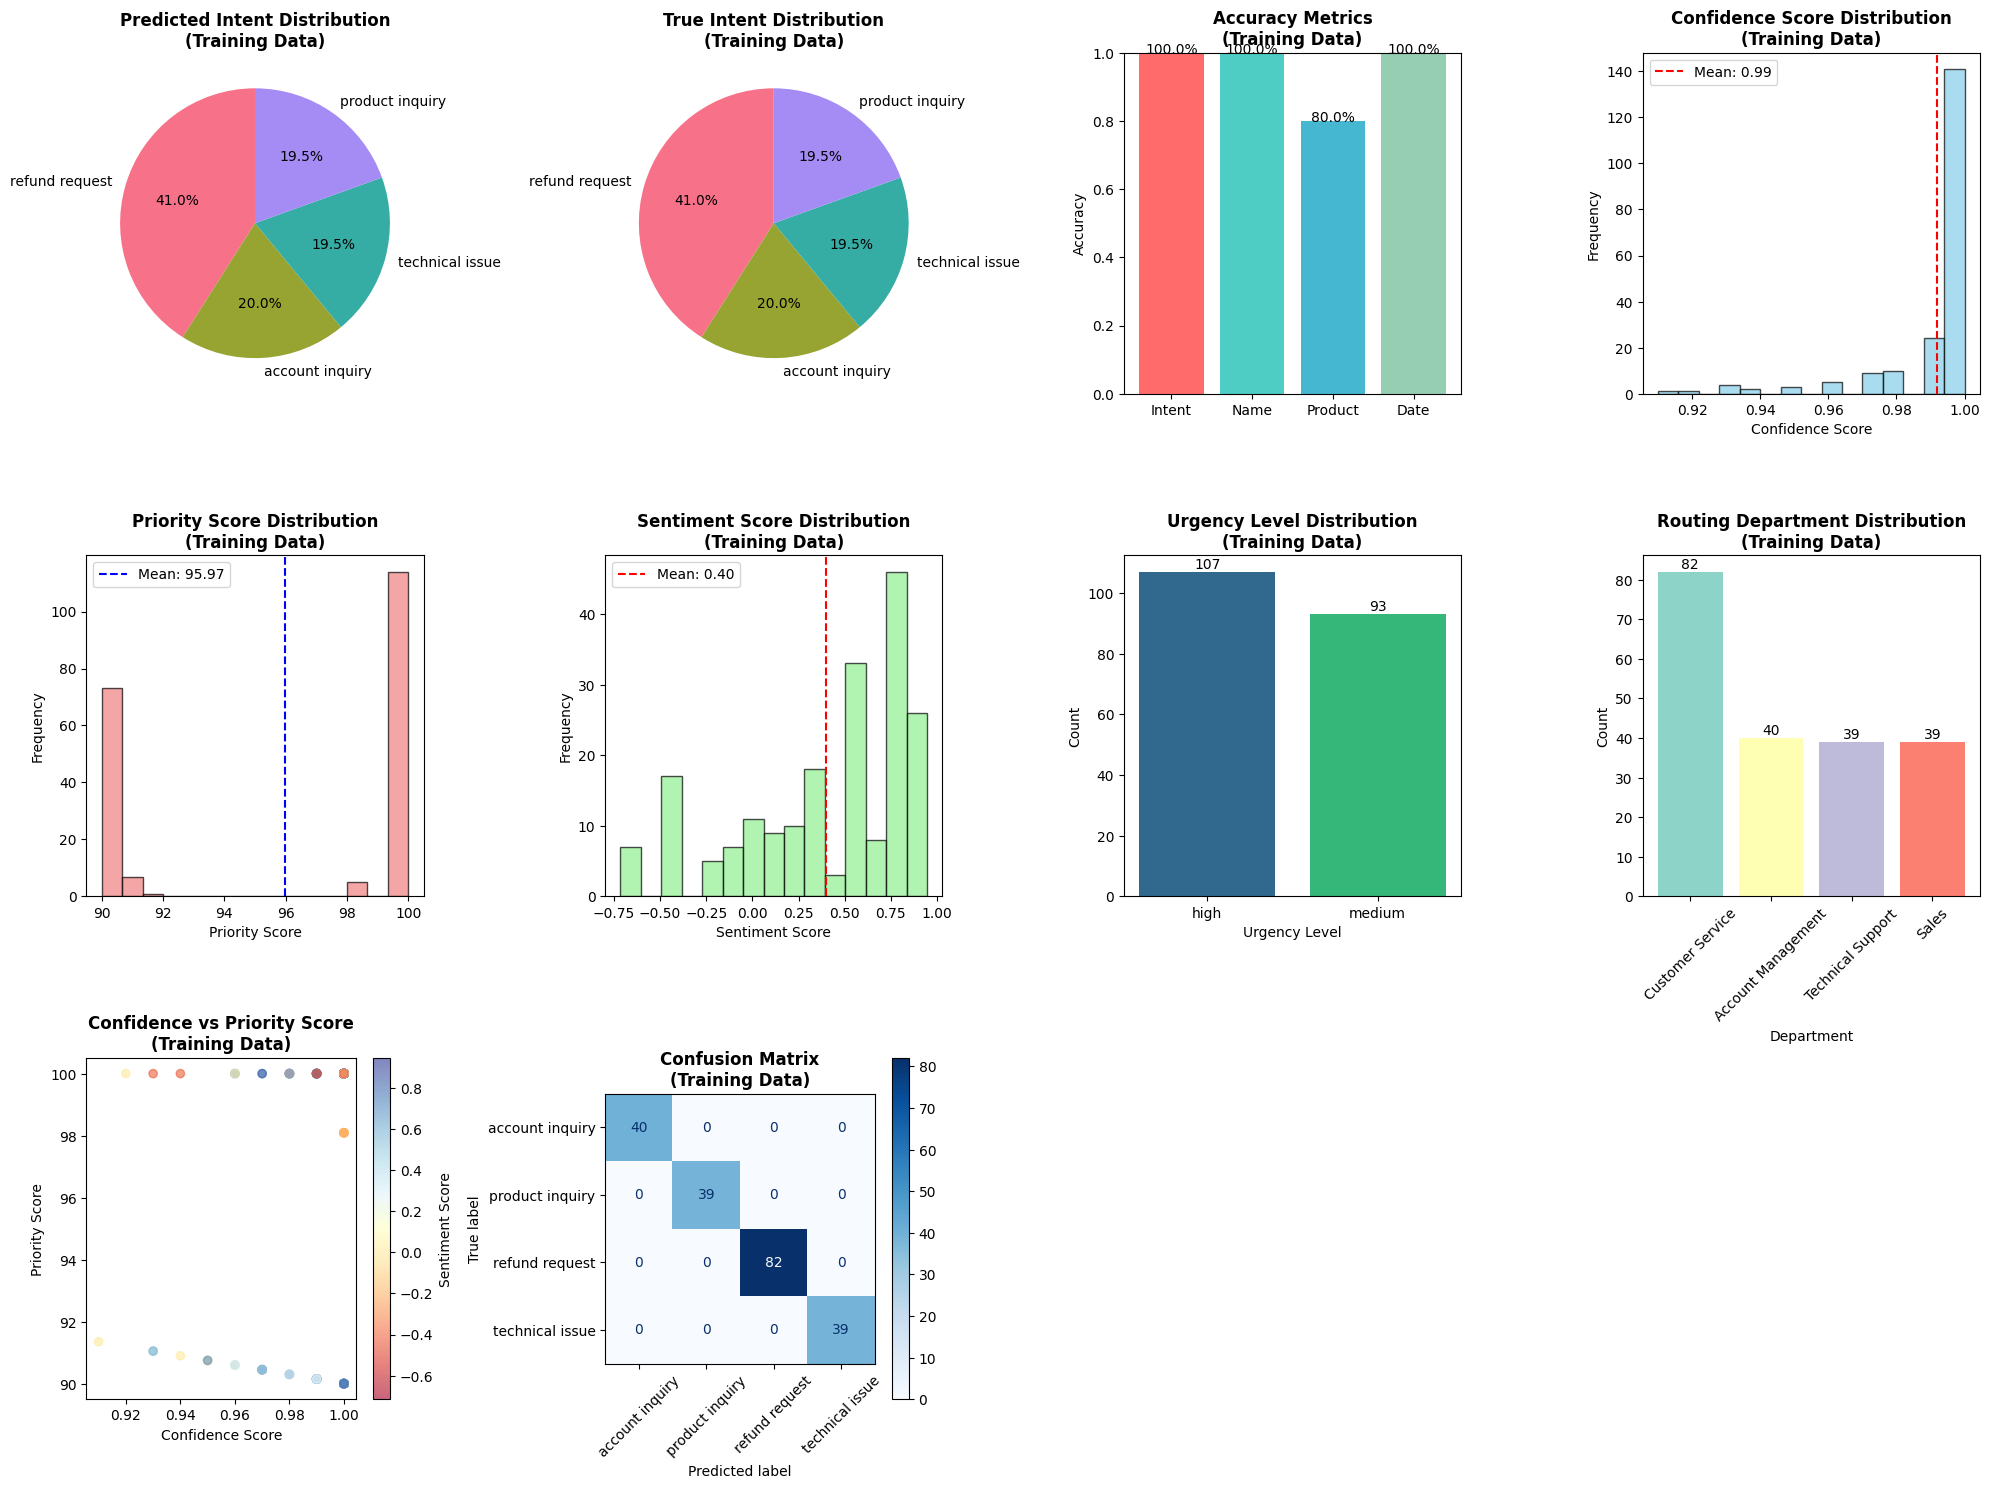


Reading content of individual test emails from '/content/drive/MyDrive/Emails'...
   Successfully read content for email_1.txt
   Successfully read content for email_2.txt
   Successfully read content for email_3.txt
   Successfully read content for email_4.txt
   Successfully read content for email_5.txt
   Successfully read content for email_7.txt
   Successfully read content for email_8.txt
   Successfully read content for email_10.txt

Processing provided test emails...

--- Summary Metrics for Processed Test Emails ---
 Model Performance:
   Intent Classification Accuracy: 100.0%
   Customer Name Extraction Accuracy: 100.0%
   Product Extraction Accuracy: 100.0%
   Date Extraction Accuracy: 100.0%

 Predicted Intent Distribution:
   refund request: 2 emails (25.0%)
   technical issue: 2 emails (25.0%)
   account inquiry: 2 emails (25.0%)
   product inquiry: 2 emails (25.0%)

 Average Confidence Score for Intent Prediction: 0.95
 Average Priority Score (Test Data): 97.67

--- Deta

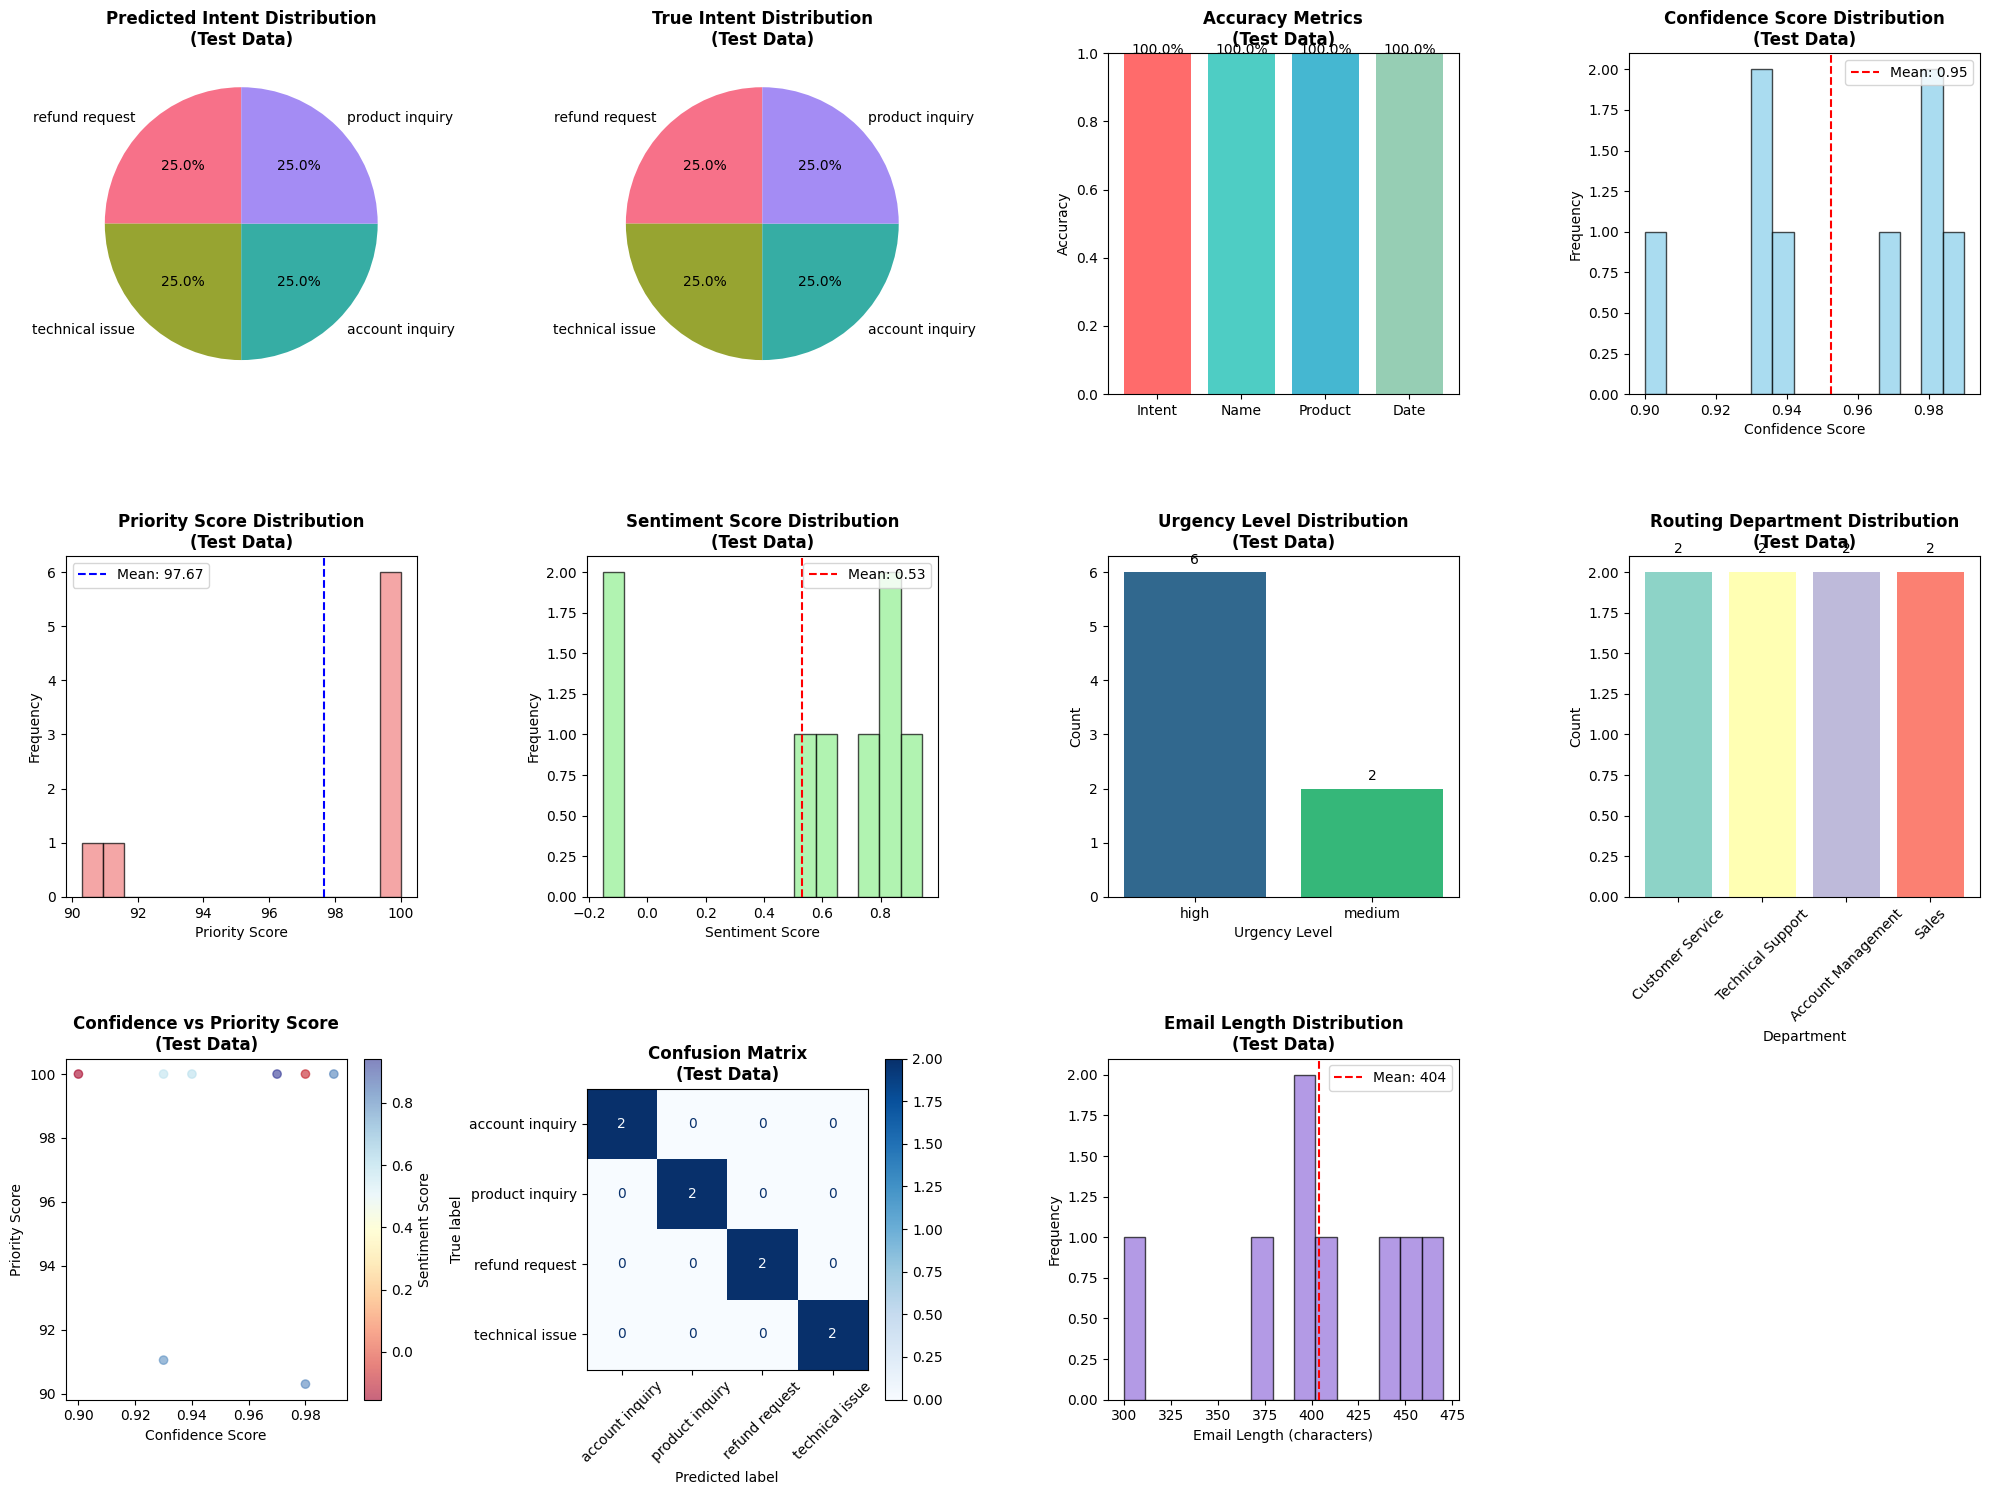

In [10]:
def main():
    """Main processing pipeline for local test emails """

    print(" Initializing Email Insight Extractor...")
    generator = AdvancedEmailGenerator() # Used for synthetic training data and sentiment
    classifier = MultiModelEmailClassifier()
    extractor = AdvancedEntityExtractor()
    priority_scorer = EmailPriorityScorer() # Initialize the new priority scorer
    routing_engine = EmailRoutingEngine()    # Initialize the new routing engine

    # Generate synthetic emails for training the classifier
    print("\n Generating synthetic email dataset for training...")
    training_emails = generator.generate_emails(num_emails=200) # Change the training data as needed
    print(f" Generated {len(training_emails)} synthetic emails for training.")

    # Train classifier
    print("\n Training Classification models...")
    classifier.fit(training_emails)

    # --- Package the trained model using pickle ---
    model_filename = 'email_intent_classifier.pkl'
    with open(model_filename, 'wb') as file:
        pickle.dump(classifier, file)
    print(f"Model successfully packaged and saved as '{model_filename}' in the Colab environment.")

    # --- Load the packaged model (demonstration of loading) ---
    with open(model_filename, 'rb') as file:
        loaded_classifier = pickle.load(file)
    print(f"Model successfully loaded from '{model_filename}' for demonstration.")

    # Convert training_emails to DataFrame for visualization of true intents
    generated_emails_df = pd.DataFrame(training_emails)

    # --- Process Training Data for Metrics ---
    print("\nProcessing Training Emails for Summary Metrics...")
    training_results = []
    # Lists to store true and predicted labels for metrics
    y_train_true = []
    y_train_pred = []

    for email_data in training_emails:
        full_content = email_data['full_content']
        predicted_intent, confidence = loaded_classifier.predict_intent(full_content)
        entities = extractor.extract_all(full_content, predicted_intent)

        urgency_level = email_data.get('urgency_level', 'medium')
        sentiment_score = email_data.get('sentiment_score', 0)

        processed_email_info = {
            "predicted_intent": predicted_intent,
            "confidence": confidence,
            "urgency_level": urgency_level,
            "sentiment_score": sentiment_score
        }

        priority_score = priority_scorer.calculate_priority_score(processed_email_info)
        processed_email_info['priority_score'] = priority_score

        routing_recommendation = routing_engine.route_email(processed_email_info)

        training_results.append({
            "email_id": email_data['id'],
            "intent": predicted_intent,
            "confidence": confidence,
            "extracted_customer_name": entities['customer_name'],
            "extracted_product": entities['product'],
            "extracted_date_of_issue": entities['date_of_issue'],
            "true_intent": email_data['true_intent'],
            "true_customer": email_data['true_customer'],
            "true_product": email_data['true_product'],
            "true_date": email_data['true_date'],
            "urgency_level": urgency_level,
            "sentiment_score": sentiment_score,
            "priority_score": priority_score,
            "routing": routing_recommendation,
            "accuracy_check": {
                "intent_correct": predicted_intent == email_data['true_intent'],
                "name_correct": entities['customer_name'] == email_data['true_customer'],
                "product_correct": entities['product'] == email_data['true_product'],
                "date_correct": entities['date_of_issue'] == email_data['true_date']
            }
        })
        y_train_true.append(email_data['true_intent'])
        y_train_pred.append(predicted_intent)

    print("\n--- Summary Metrics for Training Data ---")
    if training_results:
        training_results_df = pd.DataFrame(training_results)

        train_intent_accuracy = training_results_df['accuracy_check'].apply(lambda x: x['intent_correct']).mean()
        train_name_accuracy = training_results_df['accuracy_check'].apply(lambda x: x['name_correct']).mean()
        train_product_accuracy = training_results_df['accuracy_check'].apply(lambda x: x['product_correct']).mean()
        train_date_accuracy = training_results_df['accuracy_check'].apply(lambda x: x['date_correct']).mean()

        print(f" Model Performance on Training Data:")
        print(f"   Intent Classification Accuracy: {train_intent_accuracy:.1%}")
        print(f"   Customer Name Extraction Accuracy: {train_name_accuracy:.1%}")
        print(f"   Product Extraction Accuracy: {train_product_accuracy:.1%}")
        print(f"   Date Extraction Accuracy: {train_date_accuracy:.1%}")

        train_intent_dist = training_results_df['intent'].value_counts()
        print(f"\n Predicted Intent Distribution (Training Data):")
        for intent, count in train_intent_dist.items():
            print(f"   {intent}: {count} emails ({count/len(training_results):.1%})")

        train_avg_confidence = training_results_df['confidence'].mean()
        print(f"\n Average Confidence Score for Intent Prediction (Training Data): {train_avg_confidence:.2f}")

        train_avg_priority_score = training_results_df['priority_score'].mean()
        print(f" Average Priority Score (Training Data): {train_avg_priority_score:.2f}")

        print("\n--- Detailed Classification Metrics (Training Data) ---")
        print(classification_report(y_train_true, y_train_pred, zero_division=0))


        create_visualizations(training_results_df, "Training Data", generated_emails_df)

    else:
        print("No training emails were processed to generate metrics.")



    # Define the test email file names and their true values
    folder_path = '/content/drive/MyDrive/Emails'
    test_emails_metadata = [
        {"id": "email_1", "filename": "email_1.txt", "true_intent": "refund request", "true_customer": "Sarah Johnson", "true_product": "UltraSound Pro Bluetooth Speaker", "true_date": "2024-03-12", "true_action": "refund"},
        {"id": "email_2", "filename": "email_2.txt", "true_intent": "technical issue", "true_customer": "Michael Chen", "true_product": "SmartFit 5G Fitness Tracker", "true_date": "2024-02-25", "true_action": "troubleshooting"},
        {"id": "email_3", "filename": "email_3.txt", "true_intent": "account inquiry", "true_customer": "Emma Rodriguez", "true_product": "N/A", "true_date": "2024-04-05", "true_action": "account unlock"},
        {"id": "email_4", "filename": "email_4.txt", "true_intent": "product inquiry", "true_customer": "David Kim", "true_product": "AirPods Pro Max", "true_date": "2024-01-20", "true_action": "information"},
        {"id": "email_5", "filename": "email_5.txt", "true_intent": "refund request", "true_customer": "Lisa Zhang", "true_product": "RoboClean X200 Vacuum", "true_date": "2024-05-09", "true_action": "refund"},
        {"id": "email_7", "filename": "email_7.txt", "true_intent": "account inquiry", "true_customer": "Maria Garcia", "true_product": "N/A", "true_date": "2024-04-15", "true_action": "account verification"},
        {"id": "email_8", "filename": "email_8.txt", "true_intent": "product inquiry", "true_customer": "James Thompson", "true_product": "GameMaster Wireless Mouse", "true_date": "2024-02-12", "true_action": "information"},
        {"id": "email_10", "filename": "email_10.txt", "true_intent": "technical issue", "true_customer": "Daniel Brown", "true_product": "LuminaLED Smart Bulb", "true_date": "2024-03-22", "true_action": "troubleshooting"}
    ]

    test_emails_to_process = []
    print(f"\nReading content of individual test emails from '{folder_path}'...")
    for email_meta in test_emails_metadata:
        file_path = os.path.join(folder_path, email_meta['filename'])
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                full_content = f.read()
            email_meta['full_content'] = full_content
            test_emails_to_process.append(email_meta)
            print(f"   Successfully read content for {email_meta['filename']}")
        except FileNotFoundError:
            print(f"   Error: File not found for {email_meta['filename']}. Please ensure it's uploaded to '{folder_path}'.")
        except Exception as e:
            print(f"   Could not read content for {email_meta['filename']}: {e}")

    # Process test emails
    print("\nProcessing provided test emails...")
    results = []
    # Lists to store true and predicted labels for metrics
    y_test_true = []
    y_test_pred = []

    if not test_emails_to_process:
        print("No test emails were successfully loaded. Cannot proceed with processing.")
        return

    for email_data in test_emails_to_process:
        full_content = email_data['full_content']

        predicted_intent, confidence = loaded_classifier.predict_intent(full_content)
        entities = extractor.extract_all(full_content, predicted_intent)

        sentiment_score = generator.sentiment_analyzer.polarity_scores(full_content)['compound']
        urgency_level = "high" if any(word in full_content.lower() for word in ["urgent", "asap", "immediate", "emergency"]) else "medium"

        processed_email_info = {
            "predicted_intent": predicted_intent,
            "confidence": confidence,
            "urgency_level": urgency_level,
            "sentiment_score": sentiment_score
        }

        priority_score = priority_scorer.calculate_priority_score(processed_email_info)
        processed_email_info['priority_score'] = priority_score

        routing_recommendation = routing_engine.route_email(processed_email_info)

        result = {
            "email_id": email_data['id'],
            "full_content": full_content.replace('\n', ' ').replace('\\n', ' '),
            "intent": predicted_intent,
            "confidence": round(confidence, 3),
            "extracted_customer_name": entities['customer_name'],
            "extracted_product": entities['product'],
            "extracted_date_of_issue": entities['date_of_issue'],
            "extracted_requested_action": entities['requested_action'],
            "true_intent": email_data['true_intent'],
            "true_customer": email_data['true_customer'],
            "true_product": email_data['true_product'],
            "true_date": email_data['true_date'],
            "urgency_level": urgency_level,
            "sentiment_score": round(sentiment_score, 3),
            "priority_score": round(priority_score, 2),
            "routing": routing_recommendation,
            "accuracy_check": {
                "intent_correct": predicted_intent == email_data['true_intent'],
                "name_correct": entities['customer_name'] == email_data['true_customer'],
                "product_correct": entities['product'] == email_data['true_product'],
                "date_correct": entities['date_of_issue'] == email_data['true_date']
            }
        }
        results.append(result)
        y_test_true.append(email_data['true_intent'])
        y_test_pred.append(predicted_intent)

    # Generate analytics and print metrics for Test Data
    print("\n--- Summary Metrics for Processed Test Emails ---")
    if results:
        results_df = pd.DataFrame(results)

        intent_accuracy = results_df['accuracy_check'].apply(lambda x: x['intent_correct']).mean()
        name_accuracy = results_df['accuracy_check'].apply(lambda x: x['name_correct']).mean()
        product_accuracy = results_df['accuracy_check'].apply(lambda x: x['product_correct']).mean()
        date_accuracy = results_df['accuracy_check'].apply(lambda x: x['date_correct']).mean()

        print(f" Model Performance:")
        print(f"   Intent Classification Accuracy: {intent_accuracy:.1%}")
        print(f"   Customer Name Extraction Accuracy: {name_accuracy:.1%}")
        print(f"   Product Extraction Accuracy: {product_accuracy:.1%}")
        print(f"   Date Extraction Accuracy: {date_accuracy:.1%}")

        intent_dist = results_df['intent'].value_counts()
        print(f"\n Predicted Intent Distribution:")
        for intent, count in intent_dist.items():
            print(f"   {intent}: {count} emails ({count/len(results):.1%})")

        avg_confidence = results_df['confidence'].mean()
        print(f"\n Average Confidence Score for Intent Prediction: {avg_confidence:.2f}")

        avg_priority_score = results_df['priority_score'].mean()
        print(f" Average Priority Score (Test Data): {avg_priority_score:.2f}")

        print("\n--- Detailed Classification Metrics (Test Data) ---")
        print(classification_report(y_test_true, y_test_pred, zero_division=0))

        cm_test = confusion_matrix(y_test_true, y_test_pred, labels=sorted(list(set(y_test_true + y_test_pred)))) # Ensure all labels are included

        print("\n Sample Extracted Data:")
        print("=" * 80)
        for i, result in enumerate(results[:3]):
            original_meta = next((m for m in test_emails_metadata if m['id'] == result['email_id']), None)
            if original_meta:
                print(f"Email {result['email_id']}:")
                display_content = result['full_content'].replace('\\\\n', ' ').replace('\n', ' ')
                print(f" Full Content (Snippet): {display_content[:150]}...")
                print(f"   Predicted Intent: {result['intent']} (True: {original_meta['true_intent']}) - Correct: {result['accuracy_check']['intent_correct']}")
                print(f"   Extracted Customer: {result['extracted_customer_name']} (True: {original_meta['true_customer']}) - Correct: {result['accuracy_check']['name_correct']}")
                print(f"   Extracted Product: {result['extracted_product']} (True: {original_meta['true_product']}) - Correct: {result['accuracy_check']['product_correct']}")
                print(f"   Extracted Date: {result['extracted_date_of_issue']} (True: {original_meta['true_date']}) - Correct: {result['accuracy_check']['date_correct']}")
                print(f"   Extracted Action: {result['extracted_requested_action']}")
                print(f"   Urgency: {result['urgency_level']}")
                print(f"   Sentiment: {result['sentiment_score']:.2f}")
                print(f"   Priority Score: {result['priority_score']:.2f}")
                print(f"   Routing Recommendation: Department: {result['routing']['department']}, Escalation: {result['routing']['escalation_level']}, SLA: {result['routing']['sla_hours']} hrs")
                print("-" * 50)
            else:
                print(f"Could not find original metadata for ID: {result['email_id']}")

        create_visualizations(results_df, "Test Data")

    else:
        print("No emails were processed to generate metrics.")


if __name__ == "__main__":
    print(" EMAIL INSIGHT EXTRACTOR")
    print("=" * 60)

    main()

## End to End Pipeline for Demonstration

Processes a pre-uploaded real email file (from test set)

Showcases the full system in action:

From raw text input → to final routing decision

Mimics live production behavior

**Outcome:** A fully integrated and testable prototype demonstrating practical email automation and triage in a support scenario.

In [11]:
def process_email_end_to_end(email_content: str, loaded_classifier, extractor, priority_scorer, routing_engine, generator):
    """
    Processes a single email and returns all parsed outputs.
    This function simulates the core processing logic outside the main pipeline class.
    """
    # 1. Classify intent
    predicted_intent, confidence = loaded_classifier.predict_intent(email_content)

    # 2. Extract entities
    entities = extractor.extract_all(email_content, predicted_intent)

    # 3. Determine urgency and sentiment
    sentiment_score = generator.sentiment_analyzer.polarity_scores(email_content)['compound']
    urgency_level = "high" if any(word in email_content.lower() for word in ["urgent", "asap", "immediate", "emergency", "help"]) else "medium"
    if "low priority" in email_content.lower(): # Refine urgency
        urgency_level = "low"

    # 4. Prepare data for priority scoring and routing
    processed_email_info = {
        "predicted_intent": predicted_intent,
        "confidence": confidence,
        "urgency_level": urgency_level,
        "sentiment_score": sentiment_score
    }

    # 5. Calculate priority score
    priority_score = priority_scorer.calculate_priority_score(processed_email_info)
    processed_email_info['priority_score'] = priority_score

    # 6. Get routing recommendation
    routing_recommendation = routing_engine.route_email(processed_email_info)

    # 7. Compile all results
    return {
        "full_content_snippet": email_content.replace('\n', ' ').replace('\\n', ' ')[:150] + "...",
        "predicted_intent": predicted_intent,
        "confidence": round(confidence, 3),
        "extracted_customer_name": entities['customer_name'],
        "extracted_product": entities['product'],
        "extracted_date_of_issue": entities['date_of_issue'],
        "extracted_requested_action": entities['requested_action'],
        "urgency_level": urgency_level,
        "sentiment_score": round(sentiment_score, 3),
        "priority_score": round(priority_score, 2),
        "routing_recommendation": routing_recommendation
    }

In [12]:

print("\n\n" + "=" * 80)
print(" CLIENT DEMONSTRATION: PROCESSING A SINGLE EMAIL WITH LOADED MODEL")
print("=" * 80)

# Define the path to the model file
client_model_filename = 'email_intent_classifier.pkl'
client_test_email_path = '/content/drive/MyDrive/Emails/email_8.txt' # Example email for demonstration

# 1. Load the trained classifier model
client_loaded_classifier = None
try:
    with open(client_model_filename, 'rb') as file:
        client_loaded_classifier = pickle.load(file)
    print(f"Client: Model '{client_model_filename}' loaded successfully.")
except FileNotFoundError:
    print(f"Client Error: Model file '{client_model_filename}' not found. Please ensure it's available.")
    exit()
except Exception as e:
    print(f"Client Error loading model: {e}")
    exit()

# 2. Initialize other necessary components for processing
client_generator = AdvancedEmailGenerator()
client_extractor = AdvancedEntityExtractor()
client_priority_scorer = EmailPriorityScorer()
client_routing_engine = EmailRoutingEngine()

# Optional: Download NLTK VADER lexicon if not already present in client's environment
# import nltk
# try:
#     nltk.data.find('sentiment/vader_lexicon.zip')
# except nltk.downloader.DownloadError:
#     print("Client: Downloading VADER lexicon for sentiment analysis...")
#     nltk.download('vader_lexicon')

# 3. Load the email content for demonstration
client_email_content = ""
try:
    with open(client_test_email_path, 'r', encoding='utf-8') as f:
        client_email_content = f.read()
    print(f"Client: Loaded email content from '{client_test_email_path}'.")
except FileNotFoundError:
    print(f"Client Error: Demo email file '{client_test_email_path}' not found. Please ensure it's available.")
    exit()
except Exception as e:
    print(f"Client Error reading demo email file: {e}")
    exit()

# 4. Process the email using the client-facing function
print("\nClient: Processing the email...")
client_parsed_output = process_email_end_to_end(
    email_content=client_email_content,
    loaded_classifier=client_loaded_classifier,
    extractor=client_extractor,
    priority_scorer=client_priority_scorer,
    routing_engine=client_routing_engine,
    generator=client_generator
)

# 5. Display the parsed output
print("\nClient: Parsed Output (JSON Format):")
print(json.dumps(client_parsed_output, indent=4))
print("\n" + "=" * 80)
print(" CLIENT DEMONSTRATION COMPLETE")
print("=" * 80)




 CLIENT DEMONSTRATION: PROCESSING A SINGLE EMAIL WITH LOADED MODEL
Client: Model 'email_intent_classifier.pkl' loaded successfully.
Client: Loaded email content from '/content/drive/MyDrive/Emails/email_8.txt'.

Client: Processing the email...

Client: Parsed Output (JSON Format):
{
    "full_content_snippet": "From: james.thompson@email.com To: support@company.com Subject: Compatibility inquiry for GameMaster Wireless Mouse Date: 2024-02-14 15:33:00  Hello, ...",
    "predicted_intent": "product inquiry",
    "confidence": 0.93,
    "extracted_customer_name": "James Thompson",
    "extracted_product": "GameMaster Wireless Mouse",
    "extracted_date_of_issue": "2024-02-12",
    "extracted_requested_action": "troubleshooting",
    "urgency_level": "high",
    "sentiment_score": 0.778,
    "priority_score": 100,
    "routing_recommendation": {
        "department": "Sales",
        "escalation_level": "Level 3",
        "sla_hours": 36
    }
}

 CLIENT DEMONSTRATION COMPLETE
